In [ ]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from io import StringIO

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

QB Variable Selection Analysis

In [3]:
FILE_PATH = r"C:\Users\Jennifer\Desktop\TJ's Stuff\OMSA\CSE 6242\Final Project\QB_features.xls"   # <-- update to your actual path

p = Path(FILE_PATH)

def load_qb_features(path: Path) -> pd.DataFrame:
    """
    Robust loader: tries Excel via different engines, then TSV/CSV fallbacks.
    Returns a pandas DataFrame.
    """
    for engine in ["openpyxl", "xlrd", "calamine"]:
        try:
            return pd.read_excel(path, engine=engine)
        except Exception:
            pass

    raw = None

    for enc in ["utf-8", "utf-8-sig", "latin-1", "utf-16"]:
        try:
            raw = path.read_bytes().decode(enc, errors="replace")
        except Exception:
            continue
        if raw is None:
            continue


        if "\t" in raw:
            try:
                return pd.read_csv(StringIO(raw), sep="\t")
            except Exception:
                pass
   
        try:
            return pd.read_csv(StringIO(raw))
        except Exception:
            pass

    raise ValueError("Could not parse file. Try saving as CSV or XLSX and retry.")

qb_raw = load_qb_features(p)
qb_raw.head()

,season,fantasy_player_id,fantasy_player_name,plays,pass_plays,rush_plays,comp,pass_yards,pass_td,interceptions,...,int_rate,sack_rate,air_ypa,yac_ypa,epa_per_pass,rush_yards_per_att,passer_share,position,fp,games
0,1999,00-0000104,T.Aikman,446,428,18,240,2676,15,12,...,0.028037,0.042506,0.0,0.000000,-0.015192,0.666667,0.959641,QB,150.239997,13
1,1999,00-0000722,T.Banks,345,323,22,151,1973,17,7,...,0.021672,0.082386,0.0,0.000000,-0.057348,3.909091,0.936232,QB,141.519998,10
2,1999,00-0000865,C.Batch,308,280,28,134,1796,12,7,...,0.025000,0.105431,0.0,0.132143,-0.059708,3.107143,0.909091,QB,126.539997,10
3,1999,00-0001218,S.Beuerlein,601,574,27,321,4114,31,15,...,0.026132,0.071197,0.0,0.155052,0.076084,4.444444,0.955075,QB,282.559995,15
4,1999,00-0001335,J.Blake,455,395,60,202,2529,16,10,...,0.025316,0.063981,0.0,0.000000,0.032399,5.483333,0.868132,QB,190.059998,13


In [4]:
def clean_col(c: str) -> str:
    c = str(c).strip().lower()
    c = re.sub(r"[^0-9a-zA-Z]+", "_", c)
    c = re.sub(r"_+", "_", c).strip("_")
    return c

qb = qb_raw.copy()
qb.columns = [clean_col(c) for c in qb.columns]

print("Shape:", qb.shape)
print("Columns:", list(qb.columns))
qb.sample(5, random_state=1)

Shape: (1124, 31)
Columns: ['season', 'fantasy_player_id', 'fantasy_player_name', 'plays', 'pass_plays', 'rush_plays', 'comp', 'pass_yards', 'pass_td', 'interceptions', 'sacks', 'air_yards', 'yac', 'epa_sum', 'rush_yards', 'rush_td', 'scrambles', 'team', 'comp_pct', 'ypa', 'td_rate', 'int_rate', 'sack_rate', 'air_ypa', 'yac_ypa', 'epa_per_pass', 'rush_yards_per_att', 'passer_share', 'position', 'fp', 'games']


,season,fantasy_player_id,fantasy_player_name,plays,pass_plays,rush_plays,comp,pass_yards,pass_td,interceptions,...,int_rate,sack_rate,air_ypa,yac_ypa,epa_per_pass,rush_yards_per_att,passer_share,position,fp,games
81,2000,00-0009715,R.Leaf,332,305,27,140,1650,10,16,...,0.052459,0.072948,0.000000,0.000000,-0.283696,1.777778,0.918675,QB,78.799999,9
795,2017,00-0027939,C.Newton,622,493,129,277,3122,21,13,...,0.026369,0.062738,7.742394,3.148073,0.043274,5.387597,0.792605,QB,290.379998,15
480,2009,00-0026197,C.Henne,472,457,15,258,2738,11,13,...,0.028446,0.049896,7.956236,2.402626,0.006527,2.133333,0.968220,QB,136.719996,13
534,2011,00-0021678,T.Romo,535,515,20,317,3895,29,9,...,0.017476,0.055046,7.413592,3.440777,0.152486,2.150000,0.962617,QB,264.099996,14
258,2004,00-0022039,K.Dorsey,214,209,5,105,1042,5,9,...,0.043062,0.054299,0.000000,0.000000,-0.300329,1.400000,0.976636,QB,44.379999,7


In [33]:
TARGET = "fp"  # fantasy points
assert TARGET in qb.columns, f"Expected column '{TARGET}' not found. Found: {qb.columns}"

numeric_cols = qb.select_dtypes(include=[np.number]).columns.tolist()

USE_PER_GAME_TARGET = False

if USE_PER_GAME_TARGET:
    qb = qb.copy()
    qb = qb[qb.get("games", 0).fillna(0) > 0]
    qb["fp_per_game"] = qb["fp"] / qb["games"]
    TARGET = "fp_per_game"
   
    feature_cols = [c for c in numeric_cols if c not in ["fp", "fp_per_game", "games"]]
else:
    feature_cols = [c for c in numeric_cols if c != "fp"]

X = qb[feature_cols].copy()
y = qb[TARGET].copy()

X = X.fillna(X.mean(numeric_only=True))
y = y.fillna(y.mean())

X.shape, y.shape

((1124, 26), (1124,))

pass_td          0.933151
pass_yards       0.929962
plays            0.910847
comp             0.902249
pass_plays       0.880710
games            0.858280
epa_per_pass     0.727255
epa_sum          0.721403
yac              0.660991
td_rate          0.654234
ypa              0.619317
air_yards        0.619189
rush_plays       0.615898
sacks            0.562875
comp_pct         0.536079
scrambles        0.522554
rush_yards       0.477211
rush_td          0.472954
interceptions    0.416934
yac_ypa          0.285526
Name: fp, dtype: float64

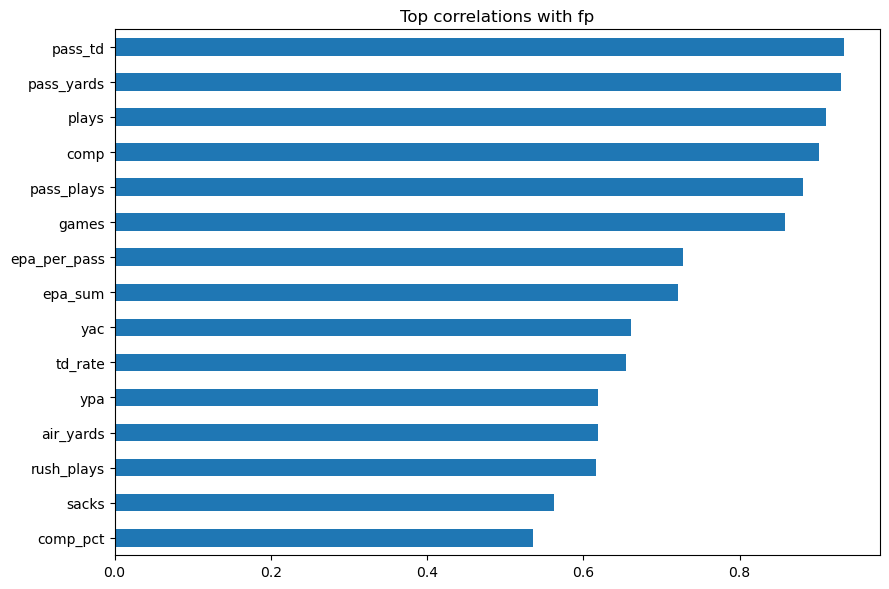

In [6]:
corr = pd.concat([X, y], axis=1).corr(numeric_only=True)[TARGET].drop(TARGET).sort_values(ascending=False)
display(corr.head(20))

# Plot top 15 correlations
plt.figure(figsize=(9,6))
corr.head(15)[::-1].plot(kind='barh')
plt.title(f"Top correlations with {TARGET}")
plt.tight_layout()
plt.show()

QB LASSO

In [7]:
lasso_pipe = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("lasso", LassoCV(cv=10, random_state=42, n_alphas=200, max_iter=10000))
])
lasso_pipe.fit(X, y)

lasso = lasso_pipe.named_steps["lasso"]
lasso_alpha = float(lasso.alpha_)
lasso_coefs = pd.Series(lasso.coef_, index=feature_cols)
lasso_selected = lasso_coefs[lasso_coefs != 0].sort_values(key=np.abs, ascending=False)

print("Chosen alpha:", lasso_alpha)
print("\nLASSO non-zero features (sorted by |coef|):")
display(lasso_selected)

pred_lasso_in = lasso_pipe.predict(X)
print("\nIn-sample R^2:", r2_score(y, pred_lasso_in))
print("In-sample MAE:", mean_absolute_error(y, pred_lasso_in))
print("In-sample RMSE:", mean_squared_error(y, pred_lasso_in, squared=False))

Chosen alpha: 0.09536334095965801

LASSO non-zero features (sorted by |coef|):


pass_yards            43.181346
pass_td               37.430999
rush_yards            15.274962
rush_td               11.809251
interceptions         -8.764316
games                  2.928754
epa_sum                1.024328
comp_pct               0.584060
rush_yards_per_att     0.575095
air_ypa               -0.552537
air_yards              0.451166
yac                    0.355060
td_rate                0.335421
dtype: float64


In-sample R^2: 0.9968033304271182
In-sample MAE: 1.5898056220020909
In-sample RMSE: 5.0289446535523465


C:\Users\Jennifer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


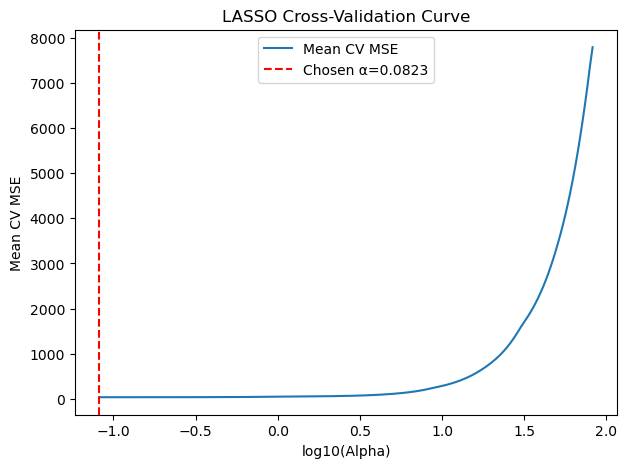

In [13]:
import numpy as np
import matplotlib.pyplot as plt

lasso = lasso_pipe.named_steps["lasso"]

plt.figure(figsize=(7,5))
plt.plot(np.log10(lasso.alphas_), lasso.mse_path_.mean(axis=1), label='Mean CV MSE')
plt.axvline(np.log10(lasso.alpha_), color='red', linestyle='--', label=f'Chosen α={lasso.alpha_:.4f}')
plt.xlabel("log10(Alpha)")
plt.ylabel("Mean CV MSE")
plt.title("LASSO Cross-Validation Curve")
plt.legend()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

lasso_pipe.fit(X_train, y_train)
y_pred_test = lasso_pipe.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred_test))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))

Test R²: 0.9989246990271728
Test MAE: 1.8170049960658738
Test RMSE: 2.95211960444151


C:\Users\Jennifer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


QB Elastic Net

In [8]:
enet_pipe = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("enet", ElasticNetCV(cv=10, random_state=42, l1_ratio=[0.3, 0.5, 0.7, 0.9, 1.0], max_iter=10000))
])
enet_pipe.fit(X, y)
enet = enet_pipe.named_steps["enet"]

enet_coefs = pd.Series(enet.coef_, index=feature_cols)
enet_selected = enet_coefs[enet_coefs != 0].sort_values(key=np.abs, ascending=False)

print("ElasticNet: alpha =", float(enet.alpha_), " l1_ratio =", float(enet.l1_ratio_))
display(enet_selected.head(20))

pred_enet_in = enet_pipe.predict(X)
print("\nElasticNet in-sample R^2:", r2_score(y, pred_enet_in))
print("ElasticNet in-sample MAE:", mean_absolute_error(y, pred_enet_in))
print("ElasticNet in-sample RMSE:", mean_squared_error(y, pred_enet_in, squared=False))

ElasticNet: alpha = 0.09543023884829831  l1_ratio = 1.0


pass_yards            43.181246
pass_td               37.431489
rush_yards            15.275009
rush_td               11.809215
interceptions         -8.764087
games                  2.928781
epa_sum                1.024411
comp_pct               0.583958
rush_yards_per_att     0.574967
air_ypa               -0.551719
air_yards              0.449990
yac                    0.355343
td_rate                0.335119
dtype: float64


ElasticNet in-sample R^2: 0.9968032831109297
ElasticNet in-sample MAE: 1.5898121348620597
ElasticNet in-sample RMSE: 5.028981871914689


C:\Users\Jennifer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


QB Stepwise

In [9]:
def stepwise_selection(X_df, y_series, threshold_in=0.01, threshold_out=0.05, verbose=False):
    included = []
    while True:
        changed = False

        excluded = list(set(X_df.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_col in excluded:
            model = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included + [new_col]]))).fit()
            new_pval[new_col] = model.pvalues[new_col]
        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True
                if verbose: print(f"Add {best_feature} (p={best_pval:.3g})")

        if included:
            model = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included]))).fit()
            pvalues = model.pvalues.iloc[1:]  # exclude intercept
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                changed = True
                if verbose: print(f"Drop {worst_feature} (p={worst_pval:.3g})")

        if not changed:
            break

    final_model = None
    if included:
        final_model = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included]))).fit()
    return included, final_model

stepwise_feats, stepwise_fit = stepwise_selection(X, y, threshold_in=0.01, threshold_out=0.05, verbose=False)

print("Stepwise-selected features:")
print(stepwise_feats)

if stepwise_fit is not None:
    display(stepwise_fit.summary())

Stepwise-selected features:
['games', 'pass_td', 'rush_td', 'rush_yards', 'pass_yards', 'interceptions', 'comp_pct', 'int_rate', 'rush_yards_per_att']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fp   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.848e+04
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:19:42   Log-Likelihood:                -3412.1
No. Observations:                1124   AIC:                             6844.
Df Residuals:                    1114   BIC:                             6894.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -13.5873      2.454     -5.538      0.000     -18.401      -8.773
games                  0.8267      0.114      7.278      0.000       0.604       1.050
pass_td                4.0439      0.042     96.668      0.000       3.962       4.126
rush_td                6.1678      0.109     56.522      0.000       5.954       6.382
rush_yards             0.0947      0.002     54.325      0.000       0.091       0.098
pass_yards             0.0376      0.001     68.486      0.000       0.037       0.039
interceptions         -2.2503      0.083    -27.156      0.000      -2.413      -2.088
comp_pct              16.2864      3.819      4.265      0.000       8.794      23.779
int_rate              98.0184     28.495      3.440      0.001      42.109     153.927
rush_yards_per_att     0.3644      0.111      3.278      0.001       0.146       0.583
==============================================================================
Omnibus:                     2269.138   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4400481.949
Skew:                          15.657   Prob(JB):                         0.00
Kurtosis:                     307.926   Cond. No.                     5.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

# LASSO
lasso_pipe.fit(X_train, y_train)
pred_tr = lasso_pipe.predict(X_train)
pred_te = lasso_pipe.predict(X_test)

print("LASSO train R^2:", r2_score(y_train, pred_tr))
print("LASSO test  R^2:", r2_score(y_test, pred_te))
print("LASSO test  MAE:", mean_absolute_error(y_test, pred_te))
print("LASSO test RMSE:", mean_squared_error(y_test, pred_te, squared=False))

if stepwise_fit is not None and len(stepwise_feats) > 0:
    Xtr_sw = sm.add_constant(X_train[stepwise_feats])
    Xte_sw = sm.add_constant(X_test[stepwise_feats], has_constant="add")
    sw_fit = sm.OLS(y_train, Xtr_sw).fit()
    pred_sw_tr = sw_fit.predict(Xtr_sw)
    pred_sw_te = sw_fit.predict(Xte_sw)

    print("\nSTEPWISE train R^2:", r2_score(y_train, pred_sw_tr))
    print("STEPWISE test  R^2:", r2_score(y_test, pred_sw_te))
    print("STEPWISE test  MAE:", mean_absolute_error(y_test, pred_sw_te))
    print("STEPWISE test RMSE:", mean_squared_error(y_test, pred_sw_te, squared=False))

LASSO train R^2: 0.9960886936132615
LASSO test  R^2: 0.9989246990271728
LASSO test  MAE: 1.8170049960658738
LASSO test RMSE: 2.95211960444151

STEPWISE train R^2: 0.9960097408072268
STEPWISE test  R^2: 0.9989704282674517
STEPWISE test  MAE: 1.7367854246847554
STEPWISE test RMSE: 2.8886653673029863


C:\Users\Jennifer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Jennifer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

lasso_cv_scores = cross_val_score(lasso_pipe, X, y, cv=kf, scoring="r2")
print("LASSO CV R^2:  mean =", lasso_cv_scores.mean().round(4), "  std =", lasso_cv_scores.std().round(4))

class StepwiseEstimator:
    def __init__(self, threshold_in=0.01, threshold_out=0.05):
        self.threshold_in = threshold_in
        self.threshold_out = threshold_out
        self.features_ = None
        self.fit_ = None
    def fit(self, X, y):
        feats, fit = stepwise_selection(pd.DataFrame(X, columns=X.columns), pd.Series(y),
                                        threshold_in=self.threshold_in, threshold_out=self.threshold_out,
                                        verbose=False)
        self.features_ = feats
        self.fit_ = sm.OLS(y, sm.add_constant(pd.DataFrame(X[feats]))).fit() if feats else None
        return self
    def predict(self, X):
        if self.fit_ is None or not self.features_:
            return np.repeat(np.mean(y), len(X))  # degenerate
        Xf = sm.add_constant(pd.DataFrame(X[self.features_]), has_constant="add")
        return self.fit_.predict(Xf)

sw_est = StepwiseEstimator()
r2s = []
for tr_idx, te_idx in kf.split(X):
    Xtr, Xte = X.iloc[tr_idx], X.iloc[te_idx]
    ytr, yte = y.iloc[tr_idx], y.iloc[te_idx]
    sw_est = StepwiseEstimator().fit(Xtr, ytr)
    pred = sw_est.predict(Xte)
    r2s.append(r2_score(yte, pred))
print("STEPWISE CV R^2: mean =", np.mean(r2s).round(4), "  std =", np.std(r2s).round(4))

LASSO CV R^2:  mean = 0.9967   std = 0.0046
STEPWISE CV R^2: mean = 0.9966   std = 0.0047


In [12]:
out_dir = Path("./qb_model_artifacts")
out_dir.mkdir(exist_ok=True)

pd.DataFrame({"feature": corr.index, "corr_with_"+TARGET: corr.values}).to_csv(out_dir / "qb_corr_with_target.csv", index=False)

lasso_selected.to_csv(out_dir / "qb_lasso_nonzero_coefs.csv", header=["coef"])
with open(out_dir / "qb_lasso_alpha.txt", "w") as f:
    f.write(str(lasso_alpha))

pd.Series(stepwise_feats, name="feature").to_csv(out_dir / "qb_stepwise_features.csv", index=False)
if stepwise_fit is not None:
    sw_coef = pd.DataFrame({"feature": ["Intercept"] + stepwise_feats, "coef": stepwise_fit.params.values})
    sw_coef.to_csv(out_dir / "qb_stepwise_coefs.csv", index=False)

print("Saved to:", out_dir.resolve())

Saved to: C:\Users\Jennifer\qb_model_artifacts


WR Variable Selection Analysis

In [17]:
import pandas as pd
import re
from pathlib import Path

WR_PATH = Path(r"C:\Users\Jennifer\Desktop\TJ's Stuff\OMSA\CSE 6242\Final Project\WR_features.xls")

def load_wr(path):
    for engine in ["openpyxl", "xlrd", "calamine"]:
        try:
            return pd.read_excel(path, engine=engine)
        except Exception:
            pass

    raw = path.read_bytes().decode("utf-8", errors="replace")
    sep = "\t" if "\t" in raw else ","
    return pd.read_csv(pd.io.common.StringIO(raw), sep=sep)

wr_raw = load_wr(WR_PATH)

def clean_col(c):
    c = str(c).strip().lower()
    c = re.sub(r"[^0-9a-zA-Z]+", "_", c)
    c = re.sub(r"_+", "_", c).strip("_")
    return c

wr_raw.columns = [clean_col(c) for c in wr_raw.columns]

print("Shape:", wr_raw.shape)
print("Columns:", list(wr_raw.columns))
wr_raw.head()

Shape: (2661, 22)
Columns: ['season', 'fantasy_player_id', 'fantasy_player_name', 'team', 'targets', 'receptions', 'rec_yards', 'rec_td', 'air_yards', 'yac', 'adot', 'ypr', 'ypt', 'yac_per_rec', 'team_targets', 'target_share', 'wr_rush_att', 'wr_rush_yards', 'wr_rush_td', 'position', 'fp', 'games']


,season,fantasy_player_id,fantasy_player_name,team,targets,receptions,rec_yards,rec_td,air_yards,yac,...,ypt,yac_per_rec,team_targets,target_share,wr_rush_att,wr_rush_yards,wr_rush_td,position,fp,games
0,1999,00-0000145,D.Alexander,KC,97,53,814,2,0,0,...,8.391753,0.0,439,0.220957,2,82,1,WR,160.600001,14
1,1999,00-0000387,R.Anthony,TB,60,30,296,1,0,0,...,4.933333,0.0,413,0.145278,1,2,0,WR,65.800001,11
2,1999,00-0000422,J.Armour,BAL,73,31,440,4,0,0,...,6.027397,0.0,450,0.162222,0,0,0,WR,99.000000,11
3,1999,00-0001317,W.Blackwell,PIT,36,20,186,0,0,0,...,5.166667,0.0,488,0.073770,0,0,0,WR,38.600000,9
4,1999,00-0001532,D.Boston,ARI,72,36,421,2,0,0,...,5.847222,0.0,484,0.148760,5,0,0,WR,90.100001,13


In [18]:
import numpy as np

TARGET = "fp"

numeric_cols = wr_raw.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

X = wr_raw[feature_cols].copy()
y = wr_raw[TARGET].copy()

X = X.fillna(X.mean())
y = y.fillna(y.mean())

print("Predictors:", len(feature_cols))
print("Rows:", len(wr_raw))

Predictors: 17
Rows: 2661


Top correlations with FP:
rec_yards        0.974378
receptions       0.948514
targets          0.850748
rec_td           0.835863
target_share     0.726487
games            0.667236
air_yards        0.571299
yac              0.558234
ypt              0.358871
ypr              0.232379
wr_rush_att      0.140520
wr_rush_yards    0.138434
adot             0.130916
wr_rush_td       0.086011
yac_per_rec      0.070181
Name: fp, dtype: float64


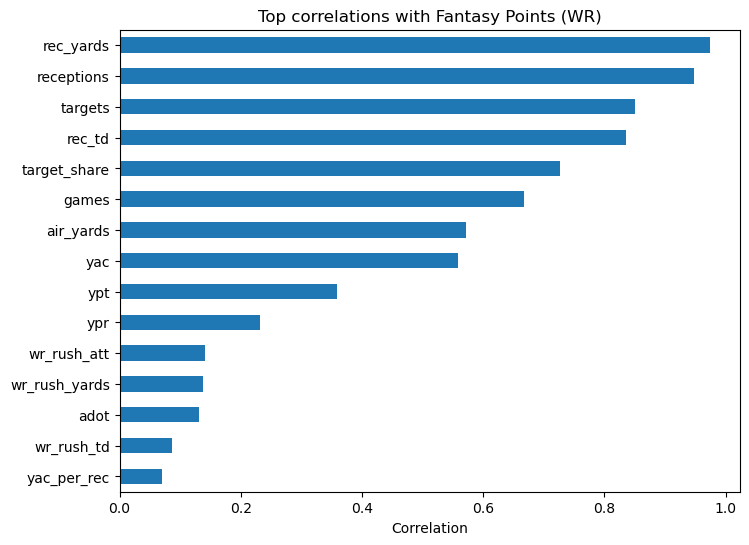

In [19]:
corr = pd.concat([X, y], axis=1).corr(numeric_only=True)[TARGET].drop(TARGET).sort_values(ascending=False)
print("Top correlations with FP:")
print(corr.head(15))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
corr.head(15)[::-1].plot(kind='barh')
plt.title("Top correlations with Fantasy Points (WR)")
plt.xlabel("Correlation")
plt.show()

WR LASSO

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=10, random_state=42, n_alphas=200, max_iter=10000))
])
lasso_pipe.fit(X, y)

lasso = lasso_pipe.named_steps["lasso"]
alpha = float(lasso.alpha_)
coefs = pd.Series(lasso.coef_, index=feature_cols)
selected = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)

print(f"Chosen alpha: {alpha}")
print("\nLASSO non-zero features:")
display(selected)

y_pred = lasso_pipe.predict(X)
print("R²:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", mean_squared_error(y, y_pred, squared=False))

Chosen alpha: 0.09266298175409017

LASSO non-zero features:


rec_yards        32.167806
receptions       23.334032
rec_td           18.101274
wr_rush_yards     2.988277
wr_rush_td        2.029606
adot             -0.085253
team_targets      0.029362
yac_per_rec      -0.024893
dtype: float64

R²: 0.9957418447692101
MAE: 1.0308619670592956
RMSE: 4.540578025016645


C:\Users\Jennifer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


WR Stepwise

In [21]:
import statsmodels.api as sm

def stepwise_selection(X_df, y_series, threshold_in=0.01, threshold_out=0.05):
    included = []
    while True:
        changed = False
        excluded = list(set(X_df.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_col in excluded:
            model = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included + [new_col]]))).fit()
            new_pval[new_col] = model.pvalues[new_col]
        if not new_pval.empty and new_pval.min() < threshold_in:
            included.append(new_pval.idxmin())
            changed = True
        model = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            included.remove(pvalues.idxmax())
            changed = True
        if not changed:
            break
    final = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included]))).fit()
    return included, final

wr_feats, wr_fit = stepwise_selection(X, y)
print("Stepwise-selected features:", wr_feats)
display(wr_fit.summary())

Stepwise-selected features: ['receptions', 'rec_td', 'rec_yards', 'wr_rush_yards', 'wr_rush_td']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fp   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.241e+05
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:01:14   Log-Likelihood:                -7803.3
No. Observations:                2661   AIC:                         1.562e+04
Df Residuals:                    2655   BIC:                         1.565e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7055      0.206      3.429      0.001       0.302       1.109
receptions        1.0109      0.011     95.541      0.000       0.990       1.032
rec_td            6.0584      0.045    136.078      0.000       5.971       6.146
rec_yards         0.0987      0.001    118.551      0.000       0.097       0.100
wr_rush_yards     0.0991      0.004     26.398      0.000       0.092       0.106
wr_rush_td        5.9368      0.327     18.166      0.000       5.296       6.578
==============================================================================
Omnibus:                     6470.337   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         54171627.503
Skew:                          25.019   Prob(JB):                         0.00
Kurtosis:                     700.194   Cond. No.                     2.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

RB Variable Analysis

In [23]:
import pandas as pd
from pathlib import Path

RB_PATH = Path(r"C:\Users\Jennifer\Desktop\TJ's Stuff\OMSA\CSE 6242\Final Project\RB_features.xls")

try:
    rb = pd.read_csv(RB_PATH, sep="\t")  # likely tab-delimited
except Exception:
    rb = pd.read_csv(RB_PATH, sep=",")   # fallback to comma-delimited

print("Shape:", rb.shape)
print("Columns:", rb.columns.tolist())
rb.head()

Shape: (1241, 36)
Columns: ['season', 'fantasy_player_id', 'fantasy_player_name', 'team', 'carries', 'rush_yards', 'rush_td', 'gl_carries', 'i10_carries', 'targets', 'receptions', 'rec_yards', 'rec_td', 'ypc', 'ypr', 'ypt', 'yac', 'air_yards', 'yac_per_rec', 'rush_epa_sum', 'rec_epa_sum', 'team_carries', 'team_targets', 'rush_share', 'target_share', 'scrimmage_yards', 'touches', 'opportunities', 'yards_per_touch', 'td_total', 'fumbles_lost_rush', 'fumbles_lost_rec', 'fumbles_lost_total', 'position', 'fp', 'games']


,season,fantasy_player_id,fantasy_player_name,team,carries,rush_yards,rush_td,gl_carries,i10_carries,targets,...,touches,opportunities,yards_per_touch,td_total,fumbles_lost_rush,fumbles_lost_rec,fumbles_lost_total,position,fp,games
0,1999,00-0000003,A.al-Jabbar,CLE,144,445,1,8,12,22,...,161,166,3.285714,2,0,0,0,RB,81.900001,13
1,1999,00-0000232,T.Allen,NE,241,870,8,17,31,18,...,255,259,3.901961,9,3,1,4,RB,167.500002,15
2,1999,00-0000251,M.Alstott,TB,220,885,6,10,13,29,...,243,249,4.547325,8,6,0,6,RB,181.500001,15
3,1999,00-0000745,T.Barber,NYG,61,255,0,3,8,77,...,114,138,6.701754,2,0,0,0,RB,141.400001,14
4,1999,00-0001102,D.Bennett,KC,141,543,8,11,18,11,...,150,152,3.893333,8,1,0,1,RB,115.400001,12


In [24]:
import numpy as np

TARGET = "fp"

numeric_cols = rb.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

X = rb[feature_cols].copy()
y = rb[TARGET].copy()

X = X.fillna(X.mean())
y = y.fillna(y.mean())

print("Rows:", len(rb))
print("Numeric predictors:", len(feature_cols))

Rows: 1241
Numeric predictors: 31


Top correlations with Fantasy Points (RB):
scrimmage_yards    0.949044
opportunities      0.859623
touches            0.844088
td_total           0.819481
rush_yards         0.809123
carries            0.736753
rush_td            0.727740
rec_yards          0.686259
receptions         0.681386
targets            0.644239
i10_carries        0.640976
rec_epa_sum        0.586604
gl_carries         0.577987
target_share       0.539254
rush_share         0.495597
Name: fp, dtype: float64


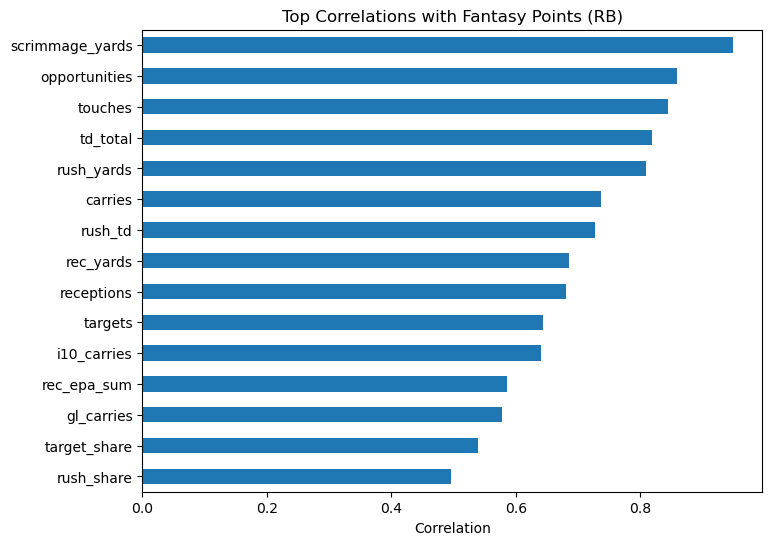

In [25]:
corr = pd.concat([X, y], axis=1).corr(numeric_only=True)[TARGET].drop(TARGET).sort_values(ascending=False)
print("Top correlations with Fantasy Points (RB):")
print(corr.head(15))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
corr.head(15)[::-1].plot(kind='barh')
plt.title("Top Correlations with Fantasy Points (RB)")
plt.xlabel("Correlation")
plt.show()

RB LASSO

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=10, random_state=42, n_alphas=200, max_iter=10000))
])
lasso_pipe.fit(X, y)

lasso = lasso_pipe.named_steps["lasso"]
alpha = float(lasso.alpha_)
coefs = pd.Series(lasso.coef_, index=feature_cols)
selected = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)

print(f"Chosen alpha: {alpha}")
print("\nLASSO non-zero features:")
display(selected)

y_pred = lasso_pipe.predict(X)
print("In-sample R²:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", mean_squared_error(y, y_pred, squared=False))

Chosen alpha: 0.06773623144473154

LASSO non-zero features:


scrimmage_yards    40.177664
td_total           25.252854
receptions         18.118297
gl_carries          0.145346
rush_epa_sum        0.022273
rush_td             0.019043
dtype: float64

In-sample R²: 0.9996905377250562
MAE: 0.7796942880859575
RMSE: 1.2555635798117628


C:\Users\Jennifer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RB Stepwise

In [27]:
import statsmodels.api as sm

def stepwise_selection(X_df, y_series, threshold_in=0.01, threshold_out=0.05):
    included = []
    while True:
        changed = False
        excluded = list(set(X_df.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_col in excluded:
            model = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included + [new_col]]))).fit()
            new_pval[new_col] = model.pvalues[new_col]
        if not new_pval.empty and new_pval.min() < threshold_in:
            included.append(new_pval.idxmin())
            changed = True
        model = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            included.remove(pvalues.idxmax())
            changed = True
        if not changed:
            break
    final = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included]))).fit()
    return included, final

rb_feats, rb_fit = stepwise_selection(X, y)
print("Stepwise-selected features:", rb_feats)
display(rb_fit.summary())

Stepwise-selected features: ['touches', 'scrimmage_yards', 'td_total', 'carries', 'receptions', 'gl_carries', 'rush_share', 'rush_epa_sum']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fp   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.788e+05
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:38:11   Log-Likelihood:                -2032.7
No. Observations:                1241   AIC:                             4081.
Df Residuals:                    1233   BIC:                             4122.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1788      0.110     -1.627      0.104      -0.394       0.037
touches             0.3400      0.002    184.853      0.000       0.336       0.344
scrimmage_yards     0.0993      0.000    259.431      0.000       0.099       0.100
td_total            6.0071      0.015    388.470      0.000       5.977       6.037
carries            -0.3347      0.001   -351.334      0.000      -0.337      -0.333
receptions          0.6747      0.002    317.490      0.000       0.671       0.679
gl_carries          0.0311      0.010      3.110      0.002       0.011       0.051
rush_share         -0.7780      0.266     -2.926      0.003      -1.300      -0.256
rush_epa_sum        0.0094      0.003      2.805      0.005       0.003       0.016
==============================================================================
Omnibus:                      797.422   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9622.664
Skew:                           2.842   Prob(JB):                         0.00
Kurtosis:                      15.401   Cond. No.                     3.59e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.24e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

TE Variable Selection Analysis

In [28]:
import pandas as pd
import re
from pathlib import Path

TE_PATH = Path(r"C:\Users\Jennifer\Desktop\TJ's Stuff\OMSA\CSE 6242\Final Project\TE_features.xls")

def load_te(path):
    for engine in ["openpyxl", "xlrd", "calamine"]:
        try:
            return pd.read_excel(path, engine=engine)
        except Exception:
            pass
    raw = path.read_bytes().decode("utf-8", errors="replace")
    sep = "\t" if "\t" in raw else ","
    from io import StringIO
    return pd.read_csv(StringIO(raw), sep=sep)

te_raw = load_te(TE_PATH)

def clean_col(c):
    c = str(c).strip().lower()
    c = re.sub(r"[^0-9a-zA-Z]+", "_", c)
    c = re.sub(r"_+", "_", c).strip("_")
    return c

te_raw.columns = [clean_col(c) for c in te_raw.columns]

print("Shape:", te_raw.shape)
print("Columns:", te_raw.columns.tolist())
te_raw.head()

Shape: (1069, 23)
Columns: ['season', 'fantasy_player_id', 'fantasy_player_name', 'team', 'targets', 'receptions', 'rec_yards', 'rec_td', 'air_yards', 'yac', 'adot', 'ypr', 'ypt', 'yac_per_rec', 'team_targets', 'target_share', 'te_rush_att', 'te_rush_yards', 'te_rush_td', 'rec_epa_sum', 'position', 'fp', 'games']


,season,fantasy_player_id,fantasy_player_name,team,targets,receptions,rec_yards,rec_td,air_yards,yac,...,yac_per_rec,team_targets,target_share,te_rush_att,te_rush_yards,te_rush_td,rec_epa_sum,position,fp,games
0,1999,00-0000166,S.Alexander,WAS,43,27,286,3,0,0,...,0.000000,501,0.085828,0,0,0,27.234057,TE,73.600000,13
1,1999,00-0000883,M.Battaglia,CIN,26,13,144,0,0,0,...,0.000000,510,0.050980,0,0,0,8.763043,TE,27.400000,7
2,1999,00-0001661,K.Brady,JAX,49,29,314,1,0,0,...,0.000000,490,0.100000,0,0,0,20.909712,TE,68.400001,12
3,1999,00-0001862,L.Broughton,PHI,43,25,289,4,0,15,...,0.600000,427,0.100703,0,0,0,28.636962,TE,77.900001,13
4,1999,00-0002102,M.Bruener,PIT,34,18,176,0,0,2,...,0.111111,488,0.069672,0,0,0,6.580995,TE,35.600001,10


In [29]:
import numpy as np

TARGET = "fp"

numeric_cols = te_raw.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET]

X = te_raw[feature_cols].copy().fillna(te_raw[feature_cols].mean())
y = te_raw[TARGET].fillna(te_raw[TARGET].mean())

print("Rows:", len(te_raw))
print("Numeric predictors:", len(feature_cols))

Rows: 1069
Numeric predictors: 18


Top correlations with Fantasy Points (TE):
rec_yards       0.968752
receptions      0.947959
rec_epa_sum     0.943296
targets         0.887588
rec_td          0.767337
air_yards       0.732448
target_share    0.723642
yac             0.662440
games           0.659513
ypt             0.351611
ypr             0.286926
adot            0.284072
yac_per_rec     0.099097
te_rush_att     0.083752
season          0.061484
Name: fp, dtype: float64


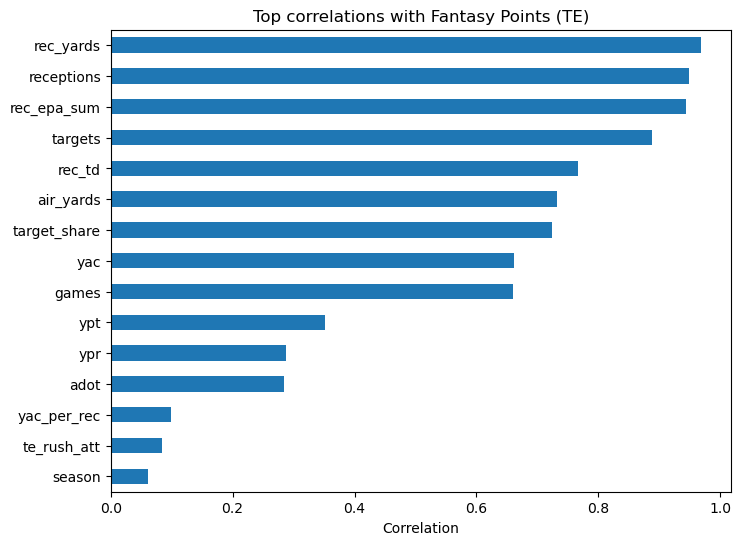

In [30]:
corr = pd.concat([X, y], axis=1).corr(numeric_only=True)[TARGET].drop(TARGET).sort_values(ascending=False)
print("Top correlations with Fantasy Points (TE):")
print(corr.head(15))

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
corr.head(15)[::-1].plot(kind='barh')
plt.title("Top correlations with Fantasy Points (TE)")
plt.xlabel("Correlation")
plt.show()

TE LASSO

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=10, random_state=42, n_alphas=200, max_iter=10000))
])
lasso_pipe.fit(X, y)

lasso = lasso_pipe.named_steps["lasso"]
alpha = float(lasso.alpha_)
coefs = pd.Series(lasso.coef_, index=feature_cols)
selected = coefs[coefs != 0].sort_values(key=np.abs, ascending=False)

print(f"Chosen alpha: {alpha}")
print("\nLASSO non-zero features:")
display(selected)

y_pred = lasso_pipe.predict(X)
print("In-sample R²:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", mean_squared_error(y, y_pred, squared=False))

Chosen alpha: 0.05076773059804733

LASSO non-zero features:


rec_yards        22.963674
receptions       19.179546
rec_td           14.762450
te_rush_td        1.290129
te_rush_yards     0.939236
rec_epa_sum       0.230411
targets           0.208822
target_share      0.084882
adot             -0.041641
te_rush_att       0.026832
dtype: float64

In-sample R²: 0.9995774076988911
MAE: 0.5228604451678263
RMSE: 1.0772986228638555


C:\Users\Jennifer\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


TE Stepwise

In [32]:
import statsmodels.api as sm

def stepwise_selection(X_df, y_series, threshold_in=0.01, threshold_out=0.05):
    included = []
    while True:
        changed = False
        excluded = list(set(X_df.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_col in excluded:
            model = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included + [new_col]]))).fit()
            new_pval[new_col] = model.pvalues[new_col]
        if not new_pval.empty and new_pval.min() < threshold_in:
            included.append(new_pval.idxmin())
            changed = True
        model = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            included.remove(pvalues.idxmax())
            changed = True
        if not changed:
            break
    final = sm.OLS(y_series, sm.add_constant(pd.DataFrame(X_df[included]))).fit()
    return included, final

te_feats, te_fit = stepwise_selection(X, y)
print("Stepwise-selected features:", te_feats)
display(te_fit.summary())

Stepwise-selected features: ['receptions', 'rec_td', 'rec_yards', 'te_rush_td', 'te_rush_yards', 'adot']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     fp   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.176e+05
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:13:36   Log-Likelihood:                -1597.8
No. Observations:                1069   AIC:                             3210.
Df Residuals:                    1062   BIC:                             3245.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1550      0.088      1.760      0.079      -0.018       0.328
receptions        1.0123      0.005    190.017      0.000       1.002       1.023
rec_td            6.0017      0.017    349.411      0.000       5.968       6.035
rec_yards         0.0997      0.000    213.719      0.000       0.099       0.101
te_rush_td        5.7247      0.214     26.750      0.000       5.305       6.145
te_rush_yards     0.1020      0.005     19.847      0.000       0.092       0.112
adot             -0.0586      0.016     -3.663      0.000      -0.090      -0.027
==============================================================================
Omnibus:                     1729.944   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1393051.501
Skew:                           9.803   Prob(JB):                         0.00
Kurtosis:                     178.758   Cond. No.                     3.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""